In [49]:
import os
import requests
import lxml
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
REGION_CODE = {
    "수정구": "41131"
}

In [50]:
def get_real_info(region_code, month):

    SEC_KEY = os.getenv("DATA_KEY")
    ENDPOINT = "http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade"

    def _parsing_month(month):
        start_y = int(month.split("-")[0][:4])
        start_m = int(month.split("-")[0][4:])
        end_y = int(month.split("-")[1][:4])
        end_m = int(month.split("-")[1][4:])

        month_list = []
        n_years = end_y - start_y + 1
        for i in range(n_years):
            yy = start_y + i
            mm = start_m
            while mm <= 12:
                month_list.append(str(yy) + str(mm).zfill(2))
                mm += 1
                if (end_y == yy) and (mm > end_m):
                    break

        return month_list
    
    month_list = _parsing_month(month)
    
    df_list = []
    for m in month_list:

        params = {
            'serviceKey': SEC_KEY,
            'LAWD_CD': region_code,
            'DEAL_YMD': m
        }

        response = requests.get(ENDPOINT, params = params)
        
        status_code = response.status_code

        print("Status Code: ", status_code)

        if status_code >= 200 and status_code <= 300:
        
            soup = BeautifulSoup(response.text, 'xml')

            yy = [i.text for i in soup.select("items > item > 년")]
            mm = [i.text for i in soup.select("items > item > 월")]
            dd = [i.text for i in soup.select("items > item > 일")]
            region = [i.text.strip(" ") for i in soup.select("items > item > 법정동")]
            apart = [i.text for i in soup.select("items > item > 아파트")]
            area = [i.text for i in soup.select("items > item > 전용면적")]
            floor = [i.text + "층" for i in soup.select("items > item > 층")]
            amount = [int(i.text.strip(" ").replace(",", "")) for i in soup.select("items > item > 거래금액")]
            category = [i.text for i in soup.select("items > item > 거래유형")]
            real_est = [i.text for i in soup.select("items > item > 중개사소재지")]
            
            date = [datetime.datetime.strptime(f"{y}-{m.zfill(2)}-{d.zfill(2)}", "%Y-%m-%d") for y, m, d in zip(yy, mm, dd)]

            colnames = ["거래날짜", "법정동", "아파트", "전용면적", "층", "거래금액", "거래유형", "중개사소재지"]

            df = pd.DataFrame(list(zip(date, region, apart, area, floor, amount, category, real_est)), columns = colnames)
            
            df_list.append(df)
        
        else:
            pass
        
    return pd.concat(df_list)
    # return df_list


In [53]:
result = get_real_info(REGION_CODE["수정구"], "202101-202302")
result

Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200
Status Code:  200


,거래날짜,법정동,아파트,전용면적,층,거래금액,거래유형,중개사소재지
0,2021-01-04,신흥동,두산,84.47,7층,80000,,
1,2021-01-04,신흥동,산성역포레스티아,84.92,21층,141000,,
2,2021-01-05,신흥동,산성역포레스티아,59.84,13층,105000,,
3,2021-01-06,신흥동,삼부르네상스파크1,84.68,2층,48000,,
4,2021-01-11,신흥동,신세계,71.31,1층,26500,,
...,...,...,...,...,...,...,...,...
14,2023-02-02,창곡동,힐스테이트위례,110.89,8층,167000,중개거래,경기 성남수정구
15,2023-02-06,창곡동,위례더힐55,85.4621,15층,69500,직거래,
16,2023-02-06,창곡동,판교밸리호반써밋,84.9872,7층,102000,중개거래,경기 성남수정구
17,2023-02-09,창곡동,위례호반베르디움,98.95,25층,119000,중개거래,경기 성남수정구


C:\Users\hanjo\AppData\Local\Temp\ipykernel_16824\2080104237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sub["ma"] = result_sub.groupby("아파트")["거래금액"].transform(lambda x: x.rolling(3, 1).mean())


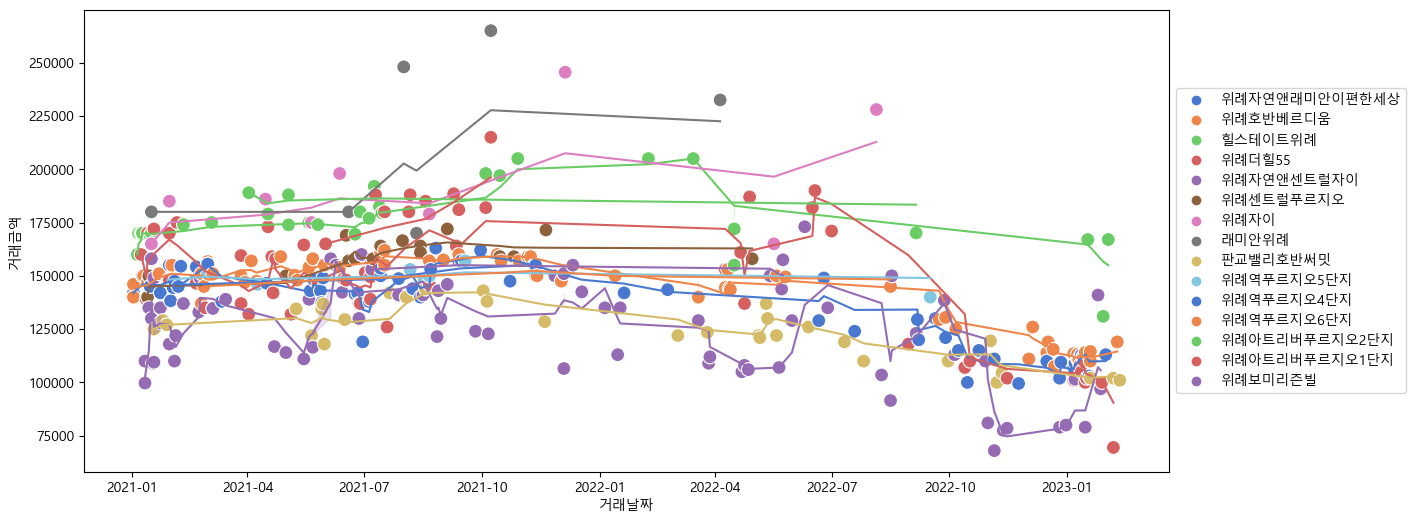

In [54]:
result_sub = result[result["법정동"] == "창곡동"]
result_sub.sort_values(by = ["거래날짜"], axis = 0)
result_sub["ma"] = result_sub.groupby("아파트")["거래금액"].transform(lambda x: x.rolling(3, 1).mean())

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(14, 6))
sns.scatterplot(x = "거래날짜",
                y = "거래금액",
                hue = "아파트",
                data = result_sub,
                palette = "muted",
                s = 100)

sns.lineplot(x = "거래날짜",
             y = "ma",
             hue = "아파트",
             data = result_sub,
             palette = "muted",
             legend = False)

sns.set_palette("colorblind")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))